In [1]:
import agentpy as ap
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from  matplotlib.ticker import FuncFormatter
import ast
import re
from landscape.multiplex import MultiplexLandscape
from networkx.algorithms import approximation
import numpy as np
%matplotlib inline

warnings.simplefilter(action='ignore')

def add_comma(match):
    return match.group(0) + ','

In [2]:
results = ap.DataDict.load('test_pcs2')
parameters = results.parameters
df = results.arrange_variables()

# for single runs
#landscapes = [str(parameters.constants.landscape)]
#df.loc[:, "landscape"] = landscapes[1]
#df.loc[:, "iteration"] = 0
#df.loc[:, "pcs"] = True
#df.loc[:, "mcs"] = True

landscapes = []
for l in parameters.sample.landscape.to_numpy():
    if l not in landscapes:
        landscapes.append(l)

Loading from directory ap_output/test_pcs2_9/
Loading variables_employee.csv - Successful
Loading parameters_sample.csv - Successful
Loading parameters_constants.json - Successful
Loading variables_manager.csv - Successful
Loading reporters.csv - Successful
Loading variables_CEO.csv - Successful
Loading info.json - Successful
Loading parameters_log.json - Successful


In [3]:
def average_org_abs_fitness_over_time(iteration, landscape):
    df_f = df[
        (df["landscape"] == landscape) & 
        #(df["iteration"] == iteration) & 
        (df["obj_type"] == "CEO")
    ][["t", "mcs", "pcs", "fitness", "abs_fitness", "iteration"]].groupby(by=["mcs", "pcs", "t", "iteration"]).mean()
    df_f = df_f.reset_index()
    df_f.loc[(df_f["pcs"] == True) & (df_f["mcs"] == False), "CS presence"] = "PCS"
    df_f.loc[(df_f["pcs"] == False) & (df_f["mcs"] == True), "CS presence"] = "MCS"
    df_f.loc[(df_f["pcs"] == True) & (df_f["mcs"] == True), "CS presence"] = "PCS + MCS"
    df_f.loc[(df_f["pcs"] == False) & (df_f["mcs"] == False), "CS presence"] = "-"
    sns.lineplot(
        data=df_f,
        x='t',
        y='abs_fitness',
        hue='CS presence'
    ).set(title="Average absolute fitness of organisations over time with added individual bias");
    
    plt.xlabel('time [weeks]')
    plt.ylabel('fitness [-]')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    plt.show()

In [4]:
def org_abs_fitness_over_time(iteration, landscape, pcs, mcs):
    df_f = df[
        (df["landscape"] == landscape) & 
        (df["iteration"] == iteration) & 
        (df["obj_type"] == "CEO") &
        (df["pcs"] == pcs) & 
        (df["mcs"] == mcs)]
    df_f.loc[:, 'org'] = df_f.groupby('obj_id').ngroup()+1
    sns.lineplot(
        data=df_f,
        x='t',
        y='abs_fitness',
        hue='org',
        legend='full'
    ).set(title="Absolute fitness of organisations over time with added individual bias");
    
    plt.xlabel('time [weeks]')
    plt.ylabel('fitness [-]')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    plt.show()

In [5]:
def org_fitness_over_time(iteration, landscape, pcs, mcs):
    df_f = df[
        (df["landscape"] == landscape) & 
        (df["iteration"] == iteration) & 
        (df["obj_type"] == "CEO") &
        (df["pcs"] == pcs) & 
        (df["mcs"] == mcs)]
    df_f.loc[:, 'org'] = df_f.groupby('obj_id').ngroup()+1
    sns.lineplot(
        data=df_f,
        x='t',
        y='fitness',
        hue='org',
        legend='full'
    ).set(title="Subjective fitness of organisations over time with added individual bias");
    
    plt.xlabel('time [weeks]')
    plt.ylabel('fitness [-]')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    plt.show()

In [6]:
def org_pcs_num_over_time(iteration, landscape, pcs, mcs):
    df_f = df[
        (df["landscape"] == landscape) & 
        (df["iteration"] == iteration) & 
        (df["obj_type"] == "CEO") &
        (df["pcs"] == pcs) & 
        (df["mcs"] == mcs)]
    df_f.loc[:, 'org'] = df_f.groupby('obj_id').ngroup()+1
    sns.lineplot(
        data=df_f,
        x='t',
        y='num_pcs',
        hue='org',
        legend='full'
    ).set(title="Number of PCS's in organisations over time");
    
    plt.xlabel('time [weeks]')
    plt.ylabel('PCS size [-]')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: int(y)))
    plt.show()

In [7]:
def bs_weights_over_time(iteration, landscape, pcs, mcs):
    df_f = df[
        (df["landscape"] == landscape) & 
        (df["iteration"] == iteration) & 
        (df["obj_type"] == "CEO") &
        (df["pcs"] == pcs) & 
        (df["mcs"] == mcs)]
    df_f.loc[:, 'org'] = df_f.groupby('obj_id').ngroup()+1

    weights = []
    for index, row in df_f.iterrows():
        s = df_f.loc[index, "belief_system"]
        #s = re.sub(r'\[[0-9\.\s]+\]', add_comma, s)
        s = re.sub(r'([0-9e\-\+\.]+)', add_comma, s)
        weights.append(eval(s))
        
    df_f[['bs_1','bs_2', 'bs_3']] = pd.DataFrame(weights, index=df_f.index)
    
    fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
    sns.lineplot(
        data=df_f,
        x='t',
        y='bs_1',
        hue='org',
        legend=False,
        ax=axs[0]
    ).set(title="layer 1");
    
    sns.lineplot(
        data=df_f,
        x='t',
        y='bs_2',
        hue='org',
        legend=False,
        ax=axs[1]
    ).set(title="layer 2");
    
    sns.lineplot(
        data=df_f,
        x='t',
        y='bs_3',
        hue='org',
        legend='full',
        ax=axs[2]
    ).set(title="layer 3");
    
    axs[0].set_ylabel("relative preference [-]")
    axs[1].set_ylabel("")
    axs[2].set_ylabel("")
    axs[0].set_xlabel("time [weeks]")
    axs[1].set_xlabel("time [weeks]")
    axs[2].set_xlabel("time [weeks]")
    fig.suptitle("Relative layer preference of organisations over time")
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    plt.show()

In [8]:
def dcs_weights_over_time(iteration, landscape, pcs, mcs):
    df_f = df[
        (df["landscape"] == landscape) & 
        (df["iteration"] == iteration) & 
        (df["obj_type"] == "manager") &
        (df["pcs"] == pcs) & 
        (df["mcs"] == mcs)]
    df_f.loc[:, 'dep'] = df_f.groupby('obj_id').ngroup()+1

    goal_term = []
    for index, row in df_f.iterrows():
        s = df_f.loc[index, "dcs_goal_term_importances"]
        #s = re.sub(r'\[[0-9\.\s]+\]', add_comma, s)
        s = re.sub(r'([0-9e\-\+\.]+)', add_comma, s)
        goal_term.append(eval(s))
        
    df_f[['goal_term_1','goal_term_2']] = pd.DataFrame(goal_term, index=df_f.index)
    
    learning_mode = []
    for index, row in df_f.iterrows():
        s = df_f.loc[index, "dcs_learning_mode_preferences"]
        #s = re.sub(r'\[[0-9\.\s]+\]', add_comma, s)
        s = re.sub(r'([0-9e\-\+\.]+)', add_comma, s)
        learning_mode.append(eval(s))
        
    df_f[['learning_mode_1','learning_mode_2', 'learning_mode_3']] = pd.DataFrame(learning_mode, index=df_f.index)
    
    personal_skill = []
    for index, row in df_f.iterrows():
        s = df_f.loc[index, "dcs_personal_skill_preferences"]
        #s = re.sub(r'\[[0-9\.\s]+\]', add_comma, s)
        s = re.sub(r'([0-9e\-\+\.]+)', add_comma, s)
        personal_skill.append(eval(s))
        
    df_f[['personal_skill_1','personal_skill_2']] = pd.DataFrame(personal_skill, index=df_f.index)
    
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(ncols=3, nrows=2, figsize=(12, 10))
    sns.lineplot(
        data=df_f,
        x='t',
        y='learning_mode_1',
        hue='dep',
        legend=False,
        ax=ax1
    ).set(title="social learning");
    
    sns.lineplot(
        data=df_f,
        x='t',
        y='learning_mode_2',
        hue='dep',
        legend=False,
        ax=ax2
    ).set(title="improving personal skills");
    
    sns.lineplot(
        data=df_f,
        x='t',
        y='learning_mode_1',
        hue='dep',
        legend=True,
        ax=ax3
    ).set(title="experimenting");
    
    sns.lineplot(
        data=df_f,
        x='t',
        y='goal_term_2',
        hue='dep',
        legend=False,
        ax=ax4
    ).set(title="long-term goals");
    
    sns.lineplot(
        data=df_f,
        x='t',
        y='personal_skill_1',
        hue='dep',
        legend=False,
        ax=ax5
    ).set(title="innovativeness");
    
    sns.lineplot(
        data=df_f,
        x='t',
        y='personal_skill_2',
        hue='dep',
        legend=False,
        ax=ax6
    ).set(title="prediction");
    
    ax1.set_ylabel("relative preference [-]")
    ax2.set_ylabel("")
    ax3.set_ylabel("")
    ax4.set_ylabel("relative preference [-]")
    ax5.set_ylabel("")
    ax6.set_ylabel("")
    ax1.set_xlabel("")
    ax2.set_xlabel("")
    ax3.set_xlabel("")
    ax4.set_xlabel("time [weeks]")
    ax5.set_xlabel("time [weeks]")
    ax6.set_xlabel("time [weeks]")
    fig.suptitle("Relative DCS lever preference of organisations over time")
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    plt.show()

In [9]:
def org_belief_system_over_time(iteration, landscape, pcs, org):
    df_f = df[
        (df["landscape"] == landscape) & 
        (df["iteration"] == iteration) & 
        (df["obj_type"] == "CEO") &
        (df["pcs"] == pcs) & 
        (df["mcs"] == True)]
    df_f.loc[:, 'org'] = df_f.groupby('obj_id').ngroup()+1
    df_f = df_f[df_f['org'] == org]
    
    weights = []
    for index, row in df_f.iterrows():
        s = df_f.loc[index, "belief_system"]
        #s = re.sub(r'\[[0-9\.\s]+\]', add_comma, s)
        s = re.sub(r'([0-9e\-\+\.]+)', add_comma, s)
        weights.append(eval(s))
        
        
    df_f[['layer 1','layer 2', 'layer 3']] = pd.DataFrame(weights, index=df_f.index)
    
    fig, ax1 = plt.subplots(figsize = (10, 7))
    df_f[['layer 1','layer 2', 'layer 3']].plot(legend=True, kind="bar", stacked=True, ax=ax1)
    ax2 = plt.twinx(ax = ax1)
    df_f.plot(x='t', y='abs_fitness', ax = ax2, legend=False, color='red')
    
    plt.title('Belief System preference weights for a given organisation over time')
    ax1.set_xlabel('time [weeks]')
    ax1.set_ylabel('relative preference [-]')
    ax2.set_ylabel('fitness [-]')
    ax1.set_xticks(ax1.get_xticks()[::10])
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    plt.show()

In [10]:
def dep_diagnostic_control_system_over_time(iteration, landscape, pcs, dep):
    df_f = df[
        (df["landscape"] == landscape) & 
        (df["iteration"] == iteration) & 
        (df["obj_type"] == "manager") &
        (df["pcs"] == pcs) & 
        (df["mcs"] == True)]
    df_f.loc[:, 'dep'] = df_f.groupby('obj_id').ngroup()+1
    df_f = df_f[df_f['dep'] == dep]
        
    goal_term = []
    for index, row in df_f.iterrows():
        s = df_f.loc[index, "dcs_goal_term_importances"]
        #s = re.sub(r'\[[0-9\.\s]+\]', add_comma, s)
        s = re.sub(r'([0-9e\-\+\.]+)', add_comma, s)
        goal_term.append(eval(s))
        
    df_f[['short-term goals','long-term goals']] = pd.DataFrame(goal_term, index=df_f.index)
    
    learning_mode = []
    for index, row in df_f.iterrows():
        s = df_f.loc[index, "dcs_learning_mode_preferences"]
        #s = re.sub(r'\[[0-9\.\s]+\]', add_comma, s)
        s = re.sub(r'([0-9e\-\+\.]+)', add_comma, s)
        learning_mode.append(eval(s))
        
    df_f[['social learning','improving personal skills', 'experimenting']] = pd.DataFrame(learning_mode, index=df_f.index)
    df_f.loc[:, 'social learning'] = df_f['long-term goals']*df_f['social learning']
    df_f.loc[:, 'improving personal skills'] = df_f['long-term goals']*df_f['improving personal skills']
    df_f.loc[:, 'experimenting'] = df_f['long-term goals']*df_f['experimenting']
          
    personal_skill = []
    for index, row in df_f.iterrows():
        s = df_f.loc[index, "dcs_personal_skill_preferences"]
        #s = re.sub(r'\[[0-9\.\s]+\]', add_comma, s)
        s = re.sub(r'([0-9e\-\+\.]+)', add_comma, s)
        personal_skill.append(eval(s))
        
    df_f[['innovativeness', 'prediction']] = pd.DataFrame(personal_skill, index=df_f.index)
    
    fig, ax1 = plt.subplots(figsize = (10, 7))
    df_f[['short-term goals', 'social learning', 'improving personal skills', 'experimenting', 'innovativeness', 'prediction']].plot(legend=True, kind="bar", stacked=True, ax=ax1)
    ax2 = plt.twinx(ax = ax1)
    df_f.plot(x='t', y='dcs_average_reward', ax = ax2, legend=False, color='darkblue')
    
    plt.title('DCS preference weights for a given department over time')
    ax1.set_xlabel('time [weeks]')
    ax1.set_ylabel('relative preference [-]')
    ax2.set_ylabel('average reward [-]')
    ax1.set_xticks(ax1.get_xticks()[::10])
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    plt.show()

In [11]:
def calculate_distance(employees, lnd):
    distances = []
    for layer in lnd.layers:
        for i, loc1 in enumerate(employees.current_location.tolist()):
            for j, loc2 in enumerate(employees.current_location.tolist()):
                if i != j:
                    distances.append(nx.shortest_path_length(layer, source=loc1, target=loc2))

    return np.mean(distances)
    
def distance_between_employees_over_time(iteration, landscape, pcs, mcs):
    lnd = MultiplexLandscape(eval(landscape))
    
    df_f = df[
        (df["landscape"] == landscape) & 
        (df["iteration"] == iteration) & 
        (df["obj_type"] == "employee") &
        (df["pcs"] == pcs) & 
        (df["mcs"] == mcs)]
    
    df_f = df_f[['org_id', 't', 'current_location']].groupby(by=['org_id', 't']).apply(lambda x: calculate_distance(x, lnd)).to_frame('distance')
    df_f = df_f.reset_index()
    df_f.loc[:, 'org'] = df_f.groupby('org_id').ngroup()+1

    sns.lineplot(
        data=df_f,
        x='t',
        y='distance',
        hue='org',
        legend='full'
    ).set(title="Average distance between employees distance between employees in organisations over timeover time");
    
    plt.xlabel('time [weeks]')
    plt.ylabel('distance [edges]')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    plt.show()

In [12]:
def aggregate_average_distances(orgs, lnd):
    orgs = orgs[['org_id', 't', 'current_location']].groupby(by=['org_id', 't']).apply(lambda x: calculate_distance(x, lnd)).to_frame('distance')
    return orgs.distance.mean()
    
def average_employee_distance_in_organisations_over_time(iteration, landscape):
    lnd = MultiplexLandscape(eval(landscape))

    df_f = df[
        (df["landscape"] == landscape) & 
        (df["iteration"] == iteration) & 
        (df["obj_type"] == "employee")
    ][["t", "mcs", "pcs", "org_id", "current_location"]].groupby(by=["mcs", "pcs", "t"]).apply(lambda x: aggregate_average_distances(x, lnd)).to_frame('average_distance')
    
    df_f = df_f.reset_index()
    df_f.loc[(df_f["pcs"] == True) & (df_f["mcs"] == False), "CS presence"] = "PCS"
    df_f.loc[(df_f["pcs"] == False) & (df_f["mcs"] == True), "CS presence"] = "MCS"
    df_f.loc[(df_f["pcs"] == True) & (df_f["mcs"] == True), "CS presence"] = "PCS + MCS"
    df_f.loc[(df_f["pcs"] == False) & (df_f["mcs"] == False), "CS presence"] = "-"
    sns.lineplot(
        data=df_f,
        x='t',
        y='average_distance',
        hue='CS presence'
    ).set(title="Average distance between employees in organisations over time");
    
    plt.xlabel('time [weeks]')
    plt.ylabel('average distance [edges]')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    plt.show()

In [13]:
def calculate_organisation_center(employees, flattened_lnd):
        
    terminals = list(set(employees.current_location.astype(int).tolist()))
    steiner_graph = approximation.steiner_tree(flattened_lnd, terminals)
    center = nx.center(steiner_graph)[0]
    return center
    
def calculate_organisation_distances(orgs, lnd):
    flattened_lnd = lnd.layers[0].copy()
    for layer in lnd.layers[1:]:
        flattened_lnd = nx.compose(flattened_lnd, layer)
        
    org_centers = orgs[['org_id', 't', 'current_location']].groupby(by=['org_id', 't']).apply(lambda x: calculate_organisation_center(x, flattened_lnd)).to_frame('center')
    terminals = list(set(org_centers.center.tolist()))
    steiner_graph = approximation.steiner_tree(flattened_lnd, terminals)
    diameter = nx.diameter(steiner_graph)
    return diameter
    
def distance_between_organisations_over_time(iteration, landscape):
    lnd = MultiplexLandscape(eval(landscape))

    df_f = df[
        (df["landscape"] == landscape) & 
        (df["iteration"] == iteration) & 
        (df["obj_type"] == "employee")
    ][["t", "mcs", "pcs", "org_id", "current_location"]].groupby(by=["mcs", "pcs", "t"]).apply(lambda x: calculate_organisation_distances(x, lnd)).to_frame('org_distance')
    
    df_f = df_f.reset_index()
    df_f.loc[(df_f["pcs"] == True) & (df_f["mcs"] == False), "CS presence"] = "PCS"
    df_f.loc[(df_f["pcs"] == False) & (df_f["mcs"] == True), "CS presence"] = "MCS"
    df_f.loc[(df_f["pcs"] == True) & (df_f["mcs"] == True), "CS presence"] = "PCS + MCS"
    df_f.loc[(df_f["pcs"] == False) & (df_f["mcs"] == False), "CS presence"] = "-"
    sns.lineplot(
        data=df_f,
        x='t',
        y='org_distance',
        hue='CS presence'
    ).set(title="Distance between organisations over time");
    
    plt.xlabel('time [weeks]')
    plt.ylabel('distance [edges]')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    plt.show()

In [14]:
def calculate_disposition(df_disp, lnd):
    flattened_lnd = lnd.layers[0].copy()
    for layer in lnd.layers[1:]:
        flattened_lnd = nx.compose(flattened_lnd, layer)
        
    for index, row in df_disp.iterrows():
        df_disp.loc[index, 'disposition'] = nx.shortest_path_length(flattened_lnd, source=row['first'], target=row['last'])
        
    return df_disp
    
def average_disposition(iteration, landscape):
    lnd = MultiplexLandscape(eval(landscape))
    
    df_f = df[
        (df["landscape"] == landscape) & 
        (df["iteration"] == iteration) & 
        (df["obj_type"] == "employee")
    ][["obj_id", "t", "mcs", "pcs", "current_location"]]
    
    df_f_first = df_f.groupby(by=["mcs", "pcs", "obj_id"]).first()
    df_f_last = df_f.groupby(by=["mcs", "pcs", "obj_id"]).last()
    df_f_first = df_f_first.reset_index()
    df_f_last = df_f_last.reset_index()
    df_f_last.loc[:, 'last'] = df_f_last['current_location']
    df_f_last.loc[:, 'first'] = df_f_first['current_location']
    df_disposition = calculate_disposition(df_f_last, lnd)
    df_disposition = df_disposition[['mcs', 'pcs', 'disposition']].groupby(by=["mcs", "pcs"]).mean()
    df_disposition = df_disposition.reset_index()
    
    df_disposition.loc[(df_disposition["pcs"] == True) & (df_disposition["mcs"] == False), "CS presence"] = "PCS"
    df_disposition.loc[(df_disposition["pcs"] == False) & (df_disposition["mcs"] == True), "CS presence"] = "MCS"
    df_disposition.loc[(df_disposition["pcs"] == True) & (df_disposition["mcs"] == True), "CS presence"] = "PCS + MCS"
    df_disposition.loc[(df_disposition["pcs"] == False) & (df_disposition["mcs"] == False), "CS presence"] = "-"
    
    df_disposition[['CS presence', 'disposition']].plot(kind="bar", legend=False, x='CS presence')
    
    plt.xlabel('CS presence')
    plt.ylabel('disposition [edges]')
    plt.title('Average final disposition of employees on the landscape')
    plt.show()

In [15]:
def calculate_distance_travelled(df_disp, lnd):
    flattened_lnd = lnd.layers[0].copy()
    for layer in lnd.layers[1:]:
        flattened_lnd = nx.compose(flattened_lnd, layer)
        
    path_length = dict(nx.all_pairs_shortest_path_length(flattened_lnd))
    distance = np.zeros(len(df_disp.index))
    
    i = 0
    for index, row in df_disp.iterrows():
        if row['t'] > 1:
            previous_loc = df_disp.loc[df_disp.index[i-1], 'current_location']
            distance[i] = path_length[int(row['current_location'])][int(previous_loc)] if row['current_location'] != previous_loc else 0
        i += 1
    
    df_disp.loc[:, 'distance'] = distance
        
    return df_disp
    
def average_distance_travelled(iteration, landscape):
    lnd = MultiplexLandscape(eval(landscape))
    
    df_f = df[
        (df["landscape"] == landscape) & 
        (df["iteration"] == iteration) & 
        (df["obj_type"] == "employee")
    ][["obj_id", "t", "mcs", "pcs", "current_location"]]
    
    df_disposition = calculate_distance_travelled(df_f, lnd)
    df_disposition = df_disposition[['mcs', 'pcs', 'distance']].groupby(by=["mcs", "pcs"]).sum()
    df_disposition.loc[:, 'distance'] = df_disposition['distance']/(8*4*6)
    df_disposition = df_disposition.reset_index()
    
    df_disposition.loc[(df_disposition["pcs"] == True) & (df_disposition["mcs"] == False), "CS presence"] = "PCS"
    df_disposition.loc[(df_disposition["pcs"] == False) & (df_disposition["mcs"] == True), "CS presence"] = "MCS"
    df_disposition.loc[(df_disposition["pcs"] == True) & (df_disposition["mcs"] == True), "CS presence"] = "PCS + MCS"
    df_disposition.loc[(df_disposition["pcs"] == False) & (df_disposition["mcs"] == False), "CS presence"] = "-"
    
    df_disposition[['CS presence', 'distance']].plot(kind="bar", legend=False, x='CS presence')
    
    plt.xlabel('CS presence')
    plt.ylabel('length [edges]')
    plt.title('Average distance travelled by employees on the landscape')
    plt.show()

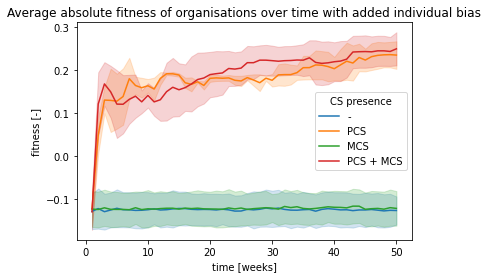

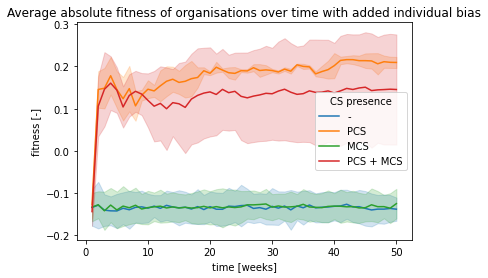

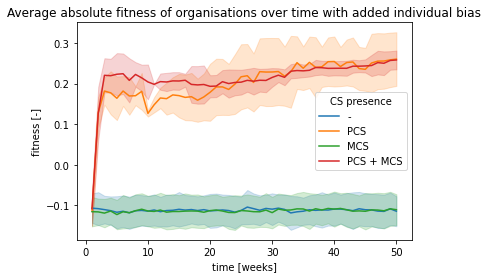

In [16]:
average_org_abs_fitness_over_time(2, landscapes[0])
average_org_abs_fitness_over_time(2, landscapes[1])
average_org_abs_fitness_over_time(2, landscapes[2])

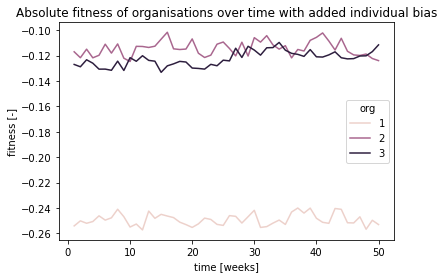

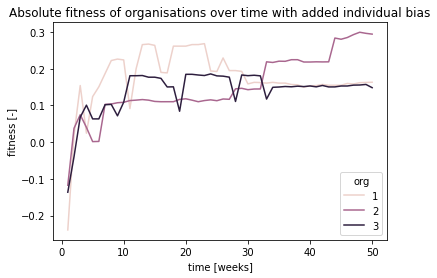

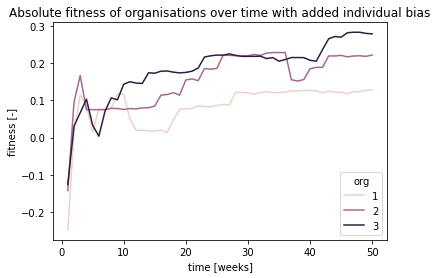

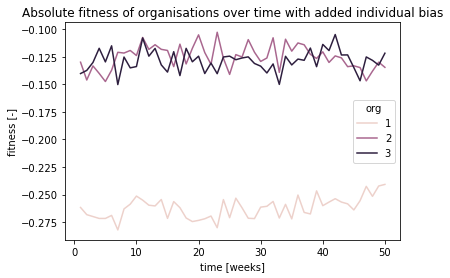

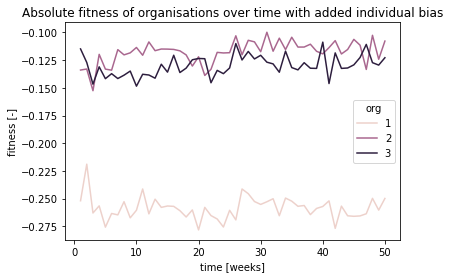

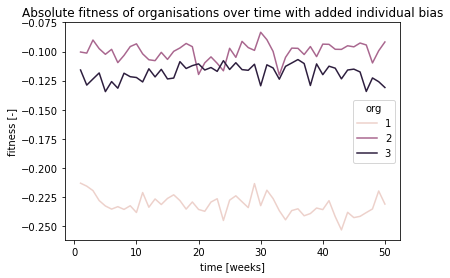

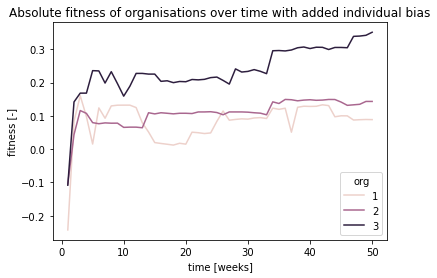

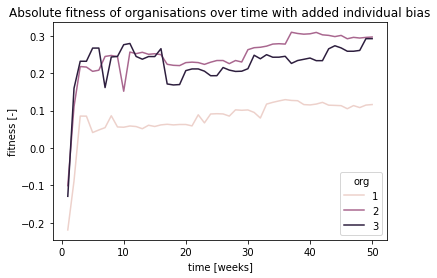

In [17]:
org_abs_fitness_over_time(0, landscapes[0], False, False)
org_abs_fitness_over_time(0, landscapes[0], False, True)
org_abs_fitness_over_time(0, landscapes[0], True, False)
org_abs_fitness_over_time(0, landscapes[0], True, True)
org_abs_fitness_over_time(0, landscapes[1], False, False)
org_abs_fitness_over_time(0, landscapes[1], False, True)
org_abs_fitness_over_time(0, landscapes[1], True, False)
org_abs_fitness_over_time(0, landscapes[1], True, True)
org_abs_fitness_over_time(0, landscapes[2], False, False)
org_abs_fitness_over_time(0, landscapes[2], False, True)
org_abs_fitness_over_time(0, landscapes[2], True, False)
org_abs_fitness_over_time(0, landscapes[2], True, True)

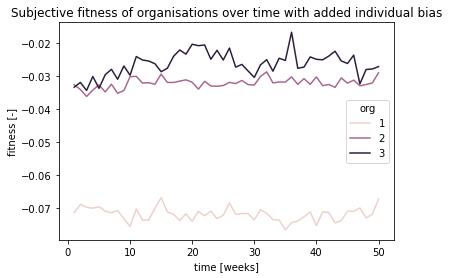

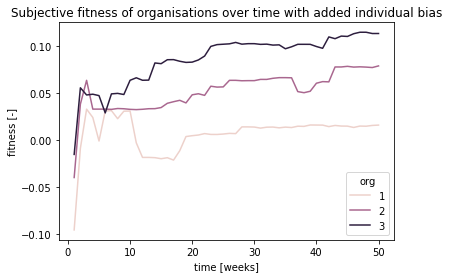

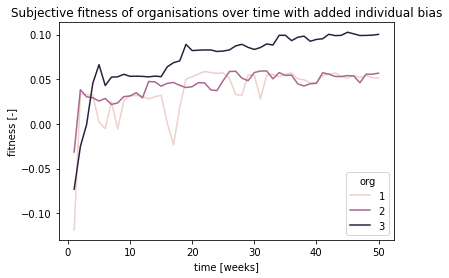

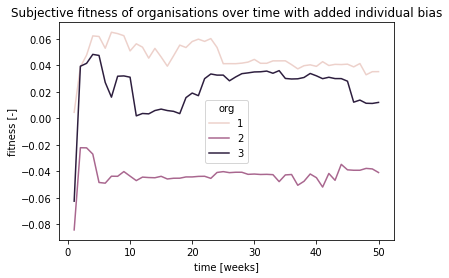

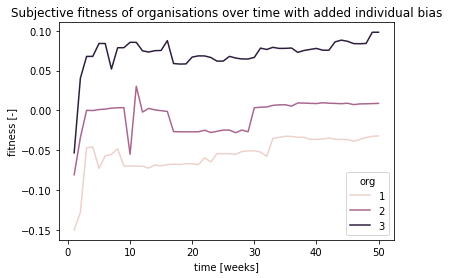

In [18]:
org_fitness_over_time(0, landscapes[0], False, False)
org_fitness_over_time(0, landscapes[0], False, True)
org_fitness_over_time(0, landscapes[0], True, False)
org_fitness_over_time(0, landscapes[0], True, True)
org_fitness_over_time(0, landscapes[1], False, False)
org_fitness_over_time(0, landscapes[1], False, True)
org_fitness_over_time(0, landscapes[1], True, False)
org_fitness_over_time(0, landscapes[1], True, True)
org_fitness_over_time(0, landscapes[2], False, False)
org_fitness_over_time(0, landscapes[2], False, True)
org_fitness_over_time(0, landscapes[2], True, False)
org_fitness_over_time(0, landscapes[2], True, True)

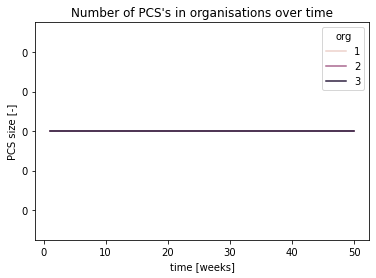

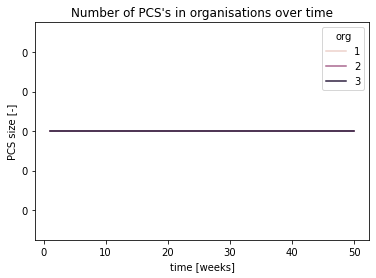

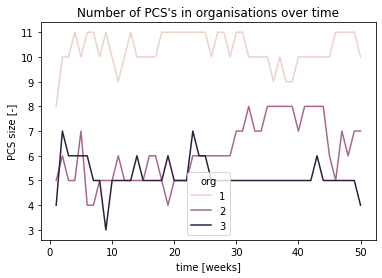

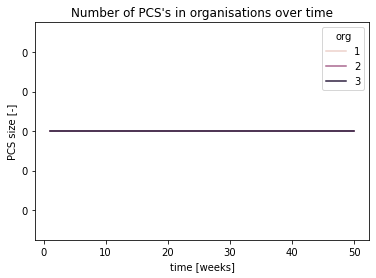

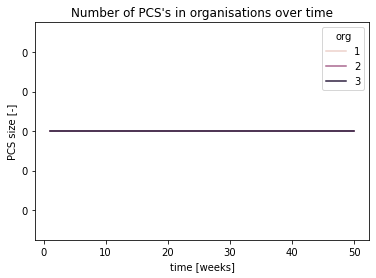

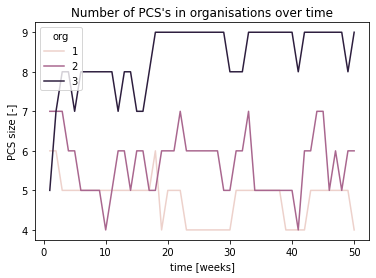

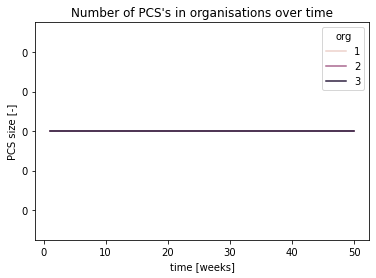

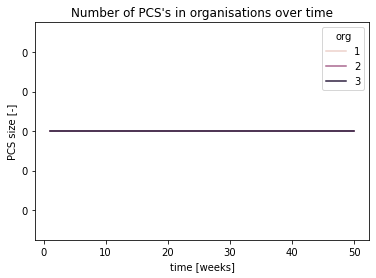

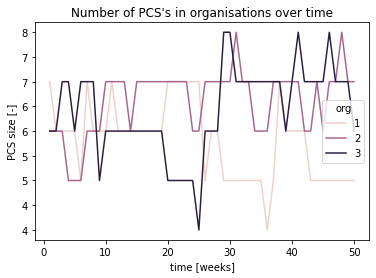

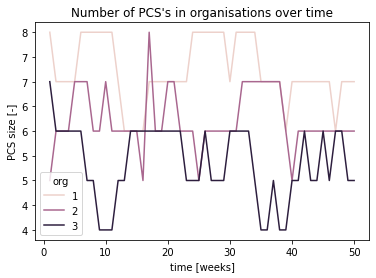

In [19]:
org_pcs_num_over_time(0, landscapes[0], False, False)
org_pcs_num_over_time(0, landscapes[0], False, True)
org_pcs_num_over_time(0, landscapes[0], True, False)
org_pcs_num_over_time(0, landscapes[0], True, True)
org_pcs_num_over_time(0, landscapes[1], False, False)
org_pcs_num_over_time(0, landscapes[1], False, True)
org_pcs_num_over_time(0, landscapes[1], True, False)
org_pcs_num_over_time(0, landscapes[1], True, True)
org_pcs_num_over_time(0, landscapes[2], False, False)
org_pcs_num_over_time(0, landscapes[2], False, True)
org_pcs_num_over_time(0, landscapes[2], True, False)
org_pcs_num_over_time(0, landscapes[2], True, True)

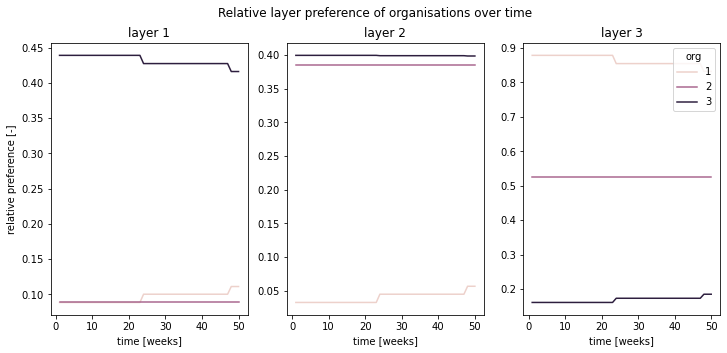

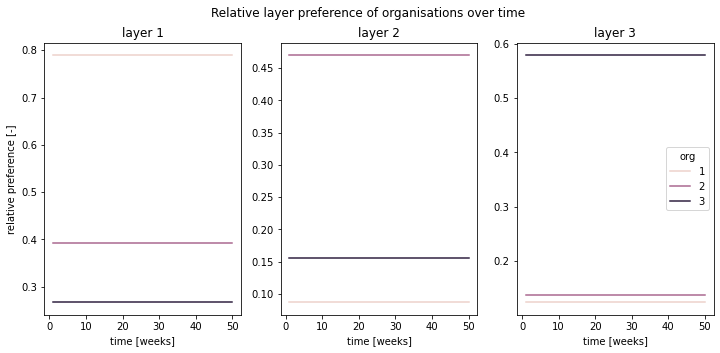

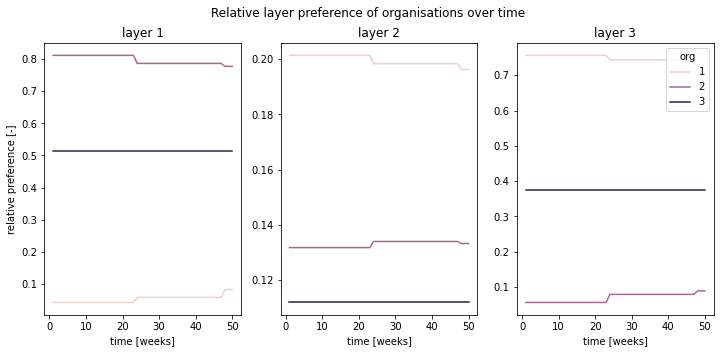

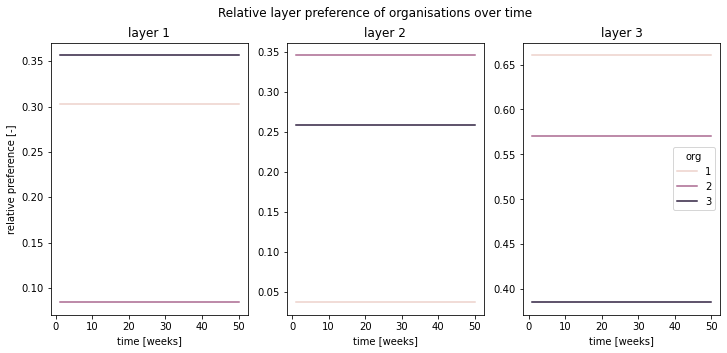

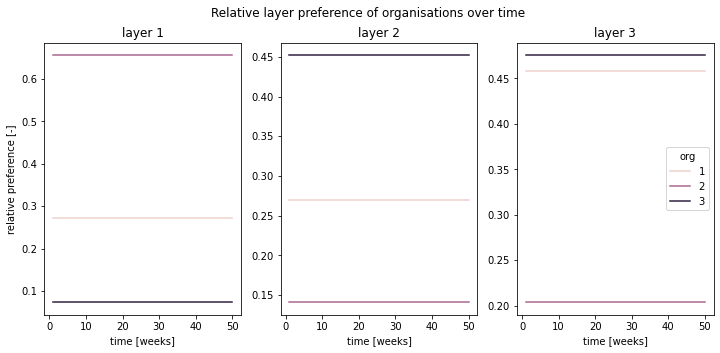

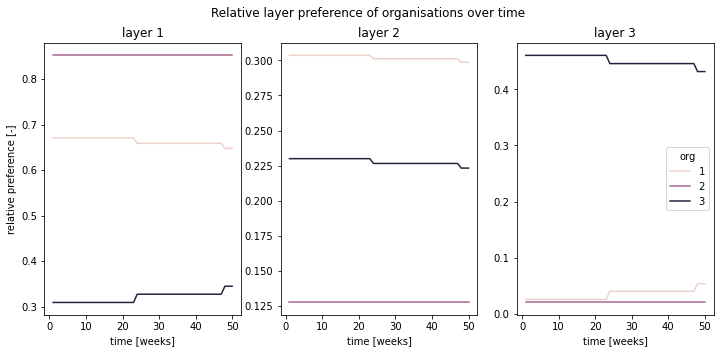

In [20]:
bs_weights_over_time(0, landscapes[0], False, False)
bs_weights_over_time(0, landscapes[0], False, True)
bs_weights_over_time(0, landscapes[0], True, False)
bs_weights_over_time(0, landscapes[0], True, True)
bs_weights_over_time(0, landscapes[1], False, False)
bs_weights_over_time(0, landscapes[1], False, True)
bs_weights_over_time(0, landscapes[1], True, False)
bs_weights_over_time(0, landscapes[1], True, True)
bs_weights_over_time(0, landscapes[2], False, False)
bs_weights_over_time(0, landscapes[2], False, True)
bs_weights_over_time(0, landscapes[2], True, False)
bs_weights_over_time(0, landscapes[2], True, True)

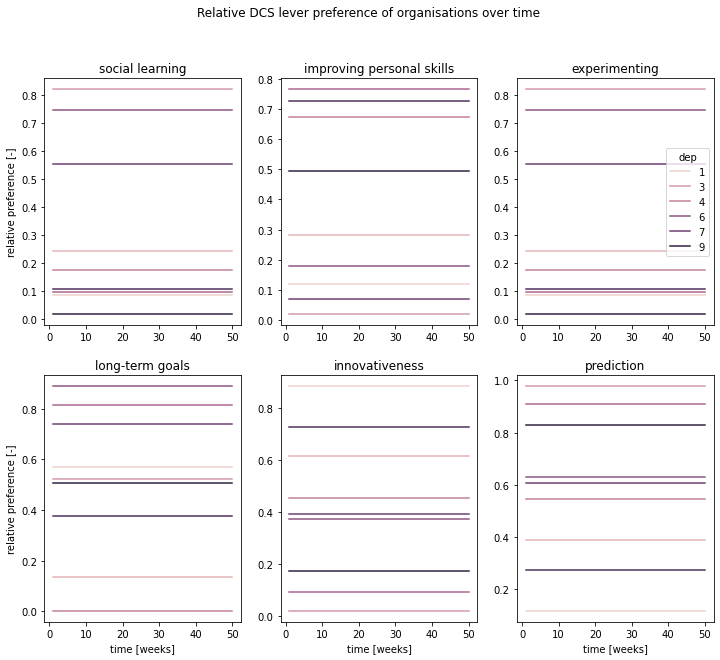

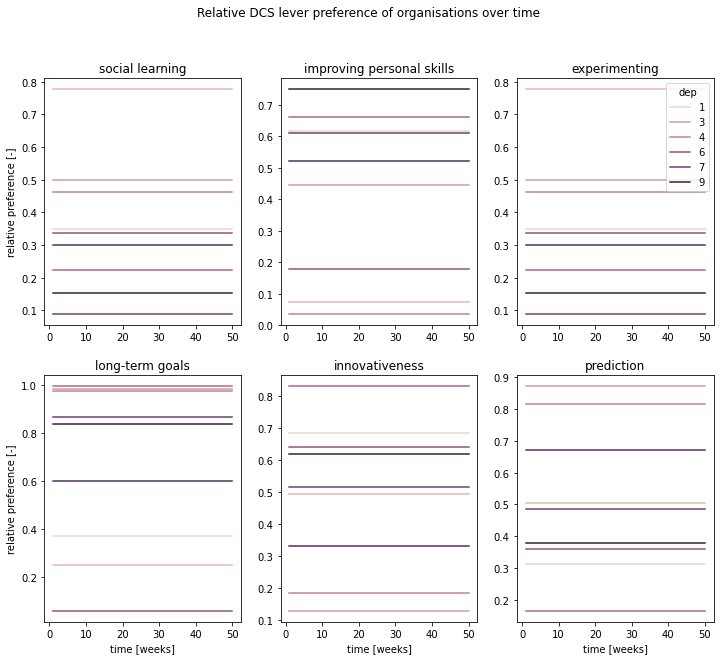

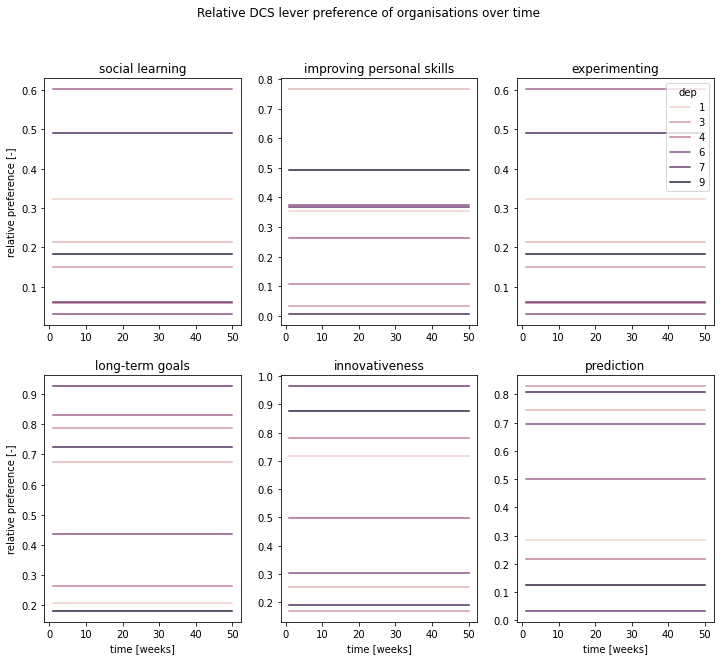

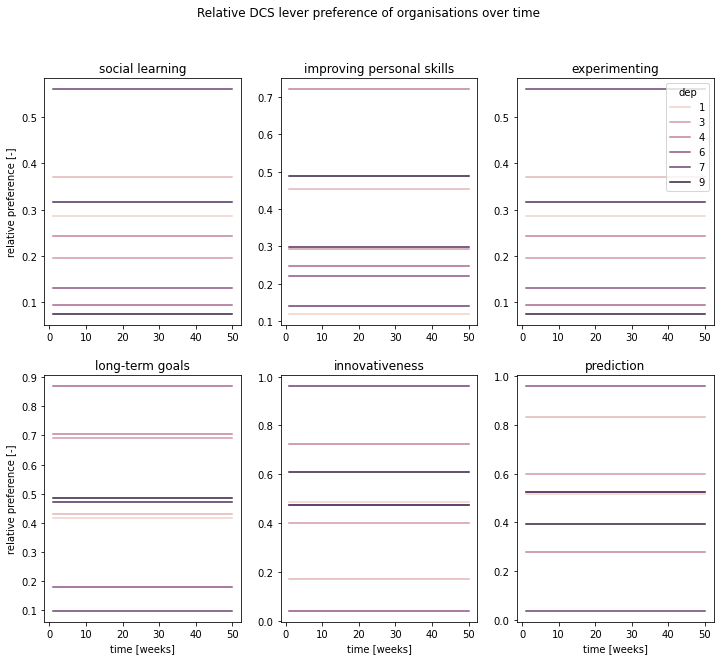

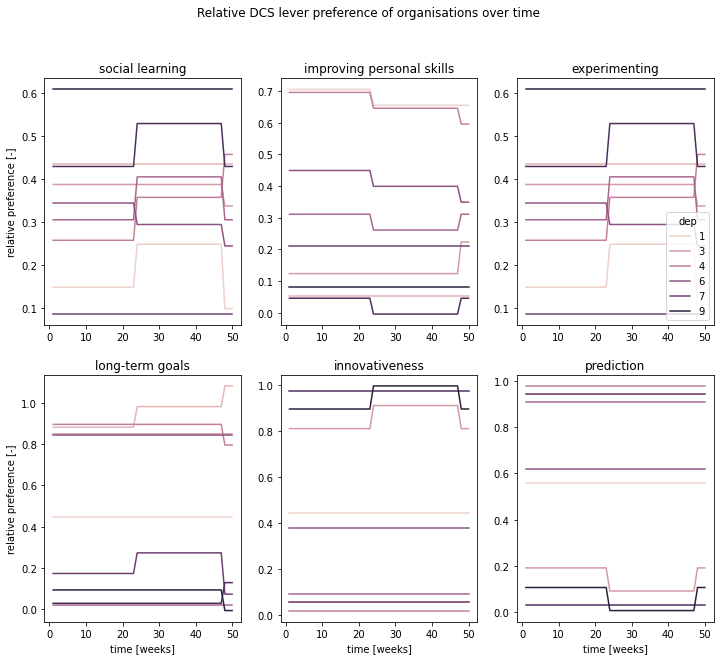

In [21]:
dcs_weights_over_time(0, landscapes[0], False, False)
dcs_weights_over_time(0, landscapes[0], False, True)
dcs_weights_over_time(0, landscapes[0], True, False)
dcs_weights_over_time(0, landscapes[0], True, True)
dcs_weights_over_time(0, landscapes[1], False, False)
dcs_weights_over_time(0, landscapes[1], False, True)
dcs_weights_over_time(0, landscapes[1], True, False)
dcs_weights_over_time(0, landscapes[1], True, True)
dcs_weights_over_time(0, landscapes[2], False, False)
dcs_weights_over_time(0, landscapes[2], False, True)
dcs_weights_over_time(0, landscapes[2], True, False)
dcs_weights_over_time(0, landscapes[2], True, True)

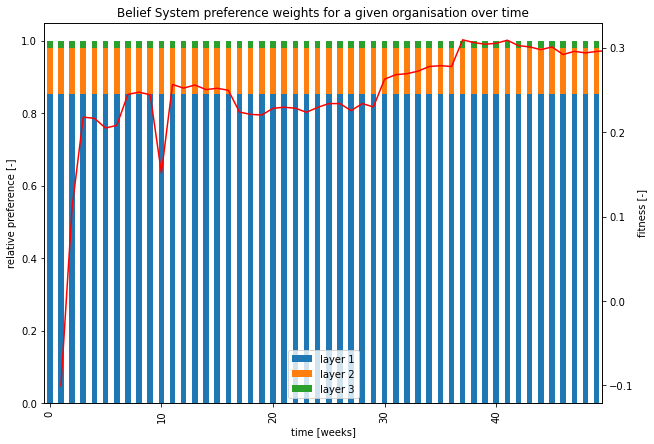

In [22]:
#org_belief_system_over_time(0, landscapes[0], False, 3)
org_belief_system_over_time(0, landscapes[2], True, 2)

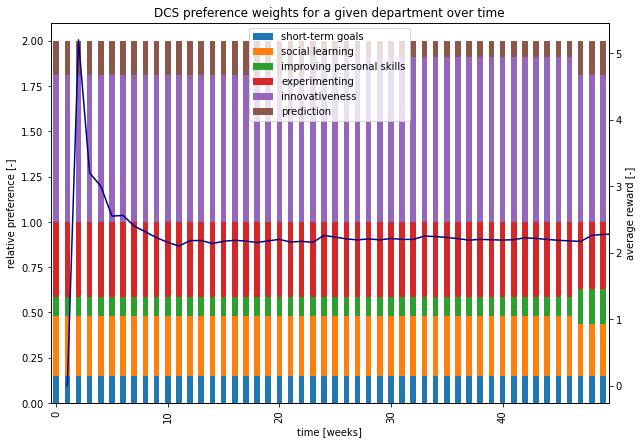

In [23]:
dep_diagnostic_control_system_over_time(0, landscapes[2], True, 3)

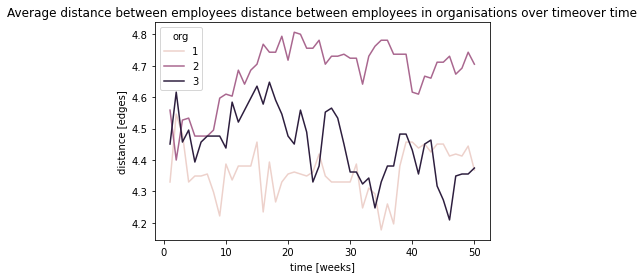

In [24]:
distance_between_employees_over_time(0, landscapes[0], True, True)

In [25]:
# draw exploration snapshot

employee_nodes = []
employee_edges = []
org_nodes = []
org_edges = []

def calculate_org_lvl_steiner(employees, flattened_lnd): 
    global employee_nodes
    global employee_edges
    global org_nodes
    
    terminals = list(set(employees.current_location.astype(int).tolist()))
    employee_nodes = employee_nodes + terminals
    steiner_graph = approximation.steiner_tree(flattened_lnd, terminals)
    employee_edges = employee_edges + list(steiner_graph.edges)
    center = nx.center(steiner_graph)[0]
    org_nodes.append(center)
    return center

def draw_exploration_snapshot(iteration, landscape, pcs, mcs, t):
    global employee_nodes
    global employee_edges
    global org_nodes
    global org_edges
    
    employee_nodes = []
    employee_edges = []
    org_nodes = []
    org_edges = []

    lnd = MultiplexLandscape(eval(landscape))
    flattened_lnd = lnd.layers[0].copy()
    for layer in lnd.layers[1:]:
        flattened_lnd = nx.compose(flattened_lnd, layer)
    
    df_f = df[
        (df["landscape"] == landscape) &
        (df["iteration"] == iteration) &
        (df["pcs"] == pcs) &
        (df["mcs"] == mcs) &
        (df["t"] == t) & 
        (df["obj_type"] == "employee")
    ]
    
    org_centers = df_f[['org_id', 'current_location']].groupby(by=['org_id']).apply(lambda x: calculate_org_lvl_steiner(x, flattened_lnd)).to_frame('center')
    terminals = list(set(org_centers.center.tolist()))
    steiner_graph = approximation.steiner_tree(flattened_lnd, terminals)
    org_edges = list(steiner_graph.edges)
    
    combined_edgelist = list(set(employee_edges + org_edges))
    G = nx.from_edgelist(combined_edgelist)

    node_color_map = []
    for node in G:
        if node in org_nodes:
            node_color_map.append('red')   
        elif node in employee_nodes:
            node_color_map.append('green')
        else: 
            node_color_map.append('blue')

    edge_color_map = []
    for edge in G:
        if edge in org_edges:
            edge_color_map.append('red')   
        elif edge in employee_edges:
            edge_color_map.append('green')
        else: 
            edge_color_map.append('black')

    nx.draw(G, node_color=node_color_map, edge_color=edge_color_map, node_size=20, pos=nx.kamada_kawai_layout(G))
    

In [26]:
#draw_exploration_snapshot(0, landscapes[0], True, True, 1)
#draw_exploration_snapshot(0, landscapes[0], True, True, 60)
draw_exploration_snapshot(0, landscapes[0], False, True, 60)

AttributeError: 'DataFrame' object has no attribute 'to_frame'

In [ ]:
average_employee_distance_in_organisations_over_time(0, landscapes[0])

In [ ]:
#distance_between_organisations_over_time(0, landscapes[0]) # takes quite long to run because of expensive network operations

In [ ]:
average_disposition(0, landscapes[0])

In [ ]:
average_distance_travelled(0, landscapes[0])